In [39]:
# https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

import torch

def create_dataset(dataset, lookback=1):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
        
    return torch.tensor(X), torch.tensor(y)

In [40]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=8, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        # optionally extract only the last time step
        # x = x[:, -1, :]
        x = self.linear(x)
        
        return x

In [41]:
import pandas as pd
import numpy as np
from model_team14 import select_features

## select imputed & transformed data
X=pd.read_csv('../data/X_data_tr.csv', index_col='date', parse_dates=True)
y=pd.read_csv('../data/y_data_tr.csv', index_col='date', parse_dates=True)
threshold=0.3
criteria=None

df_feature=pd.read_csv('milestoneII/data/df_feature.csv')

selected_features=list(df_feature[df_feature.select==1]['variable'])

# X_train, y_train = create_dataset(X[selected_features][:-96].to_numpy())
# X_train = X_train.to(torch.float32)
# y_train = y_train.to(torch.float32)

In [42]:

y_type = 'y_agg'
test_year = 8

X_train=X[selected_features][:-(test_year*12)]
y_train=y[y_type][:-(test_year*12)]           
X_test=X[selected_features][-(test_year*12):]   
y_test=y[y_type][-(test_year*12):]

X_train = torch.tensor(X_train.to_numpy()).to(torch.float32)
y_train = torch.tensor(y_train.to_numpy()).to(torch.float32)
X_test = torch.tensor(X_test.to_numpy()).to(torch.float32)
y_test = torch.tensor(y_test.to_numpy()).to(torch.float32)

# X_train, y_train = create_dataset(X_train.to_numpy())
# X_test, y_test = create_dataset(X_test.to_numpy())


In [43]:
# training 

import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=12)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()

    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

/Users/richardlieu/.local/share/virtualenvs/milestoneII-GYt9I6pr/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/richardlieu/.local/share/virtualenvs/milestoneII-GYt9I6pr/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([492])) that is different to the input size (torch.Size([492, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/richardlieu/.local/share/virtualenvs/milestoneII-GYt9I6pr/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([96])) that is different to the

Epoch 0: train RMSE 0.7978, test RMSE 0.5593
Epoch 100: train RMSE 0.9377, test RMSE 0.6449
Epoch 200: train RMSE 0.9186, test RMSE 0.6651
Epoch 300: train RMSE 0.9232, test RMSE 0.7450
Epoch 400: train RMSE 0.9201, test RMSE 0.6866
Epoch 500: train RMSE 0.8954, test RMSE 0.6968
Epoch 600: train RMSE 0.9036, test RMSE 0.6817
Epoch 700: train RMSE 0.9277, test RMSE 0.7024
Epoch 800: train RMSE 0.9094, test RMSE 0.6957
Epoch 900: train RMSE 0.9219, test RMSE 0.7031
Epoch 1000: train RMSE 0.9122, test RMSE 0.6774
Epoch 1100: train RMSE 0.8982, test RMSE 0.6766
Epoch 1200: train RMSE 0.9108, test RMSE 0.6984
Epoch 1300: train RMSE 0.9144, test RMSE 0.6969
Epoch 1400: train RMSE 0.9206, test RMSE 0.6994
Epoch 1500: train RMSE 0.9090, test RMSE 0.6985
Epoch 1600: train RMSE 0.9090, test RMSE 0.7014
Epoch 1700: train RMSE 0.9137, test RMSE 0.7096
Epoch 1800: train RMSE 0.9181, test RMSE 0.7023
Epoch 1900: train RMSE 0.9173, test RMSE 0.6990


In [48]:
print(X)

                 RPI   W875RX1  DPCERA3M086SBEA  CMRMTSPLx   RETAILx  \
date                                                                   
1974-01-01 -0.008564 -0.011916        -0.000559   0.000901  0.012460   
1974-02-01 -0.006029 -0.006476        -0.005798  -0.004919  0.005931   
1974-03-01 -0.006566 -0.006938         0.001562   0.003376  0.014301   
1974-04-01 -0.000595 -0.004942         0.003335  -0.007316  0.013271   
1974-05-01  0.000902  0.000657         0.002920   0.004392  0.011373   
...              ...       ...              ...        ...       ...   
2022-08-01  0.002957  0.004051         0.004784   0.016057  0.007019   
2022-09-01  0.001310  0.002391         0.002582   0.000578 -0.000166   
2022-10-01  0.004940  0.002038         0.002652  -0.001062  0.010397   
2022-11-01  0.002454  0.002231        -0.004145  -0.009473 -0.013201   
2022-12-01  0.001115  0.001324        -0.001938   0.014901 -0.007193   

              INDPRO   IPFPNSS   IPFINAL   IPCONGD  IPDCONGD  .

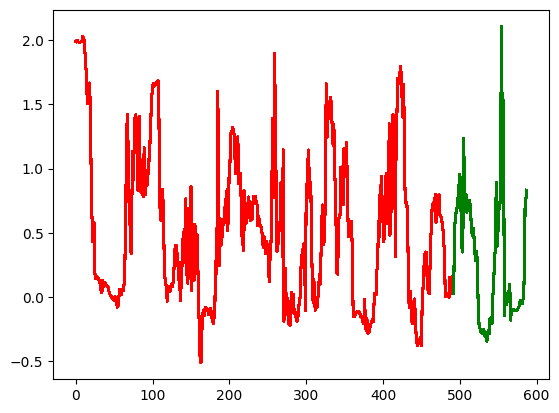

In [49]:
# plot

import matplotlib.pyplot as plt

train_size = len(X_train)

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(X) * np.nan
    # y_pred = model(X_train)
    # y_pred = y_pred[:, -1, :]
    train_plot[:train_size] = model(X_train)#[:, -1]
    # shift test predictions for plotting
    test_plot = np.ones_like(X) * np.nan
    test_plot[train_size:len(X)] = model(X_test)#[:, -1]

# plot
# plt.plot(X, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()